Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt  # required for plotting

from braket.ahs.atom_arrangement import AtomArrangement

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from collections import Counter

In [5]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

In [6]:
#@title Define the graph

a = 5.3e-6  # nearest-neighbor separation (in meters)

# Define coordiantes of the atoms in the graph A
# as a numpy array of shape (N, 2), where N is the number of nodes
graphA_nodes = np.array([[0., 0.],[0., 1.], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2 + 1., 0.5], 
                          [np.sqrt(3) + 1., 0.], [np.sqrt(3) + 1., 1.]])
graphB_nodes = np.array([[0., 0.],[0., 1.], [1., 0.], [1, 1], 
                          [2., 0.], [2., 1.]])                          
register = AtomArrangement()
for node in graphA_nodes:
    register.add(node * a)
# register.add(np.array([0.5, 0.5 + 1/np.sqrt(2)]) * a)
# register.add(np.array([0.5 + 1/np.sqrt(2), 0.5]) * a)
# register.add(np.array([0.5 + 1/np.sqrt(2), - 0.5]) * a)
# register.add(np.array([0.5, - 0.5 - 1/np.sqrt(2)]) * a)
# register.add(np.array([-0.5, - 0.5 - 1/np.sqrt(2)]) * a)
# register.add(np.array([-0.5 - 1/np.sqrt(2), - 0.5]) * a)
# register.add(np.array([-0.5 - 1/np.sqrt(2), 0.5]) * a)
# register.add(np.array([-0.5, 0.5 + 1/np.sqrt(2)]) * a)

Text(0.5, 0.98, 'Graph A')

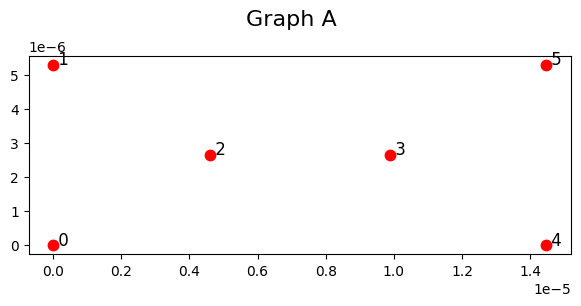

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))
xs, ys = [register.coordinate_list(dim) for dim in (0, 1)]
ax.plot(xs, ys, 'r.', ms=15)
for idx, (x, y) in enumerate(zip(xs, ys)):
    ax.text(x, y, f" {idx}", fontsize=12)
ax.set_aspect('equal')    
plt.suptitle("Graph A", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

In [8]:
#@title Define parameters of the simulation
def get_drive(time_max=4e-6):
    """AnalogHamiltonianSimulation requires a DrivingField object as input.
    This function returns a DrivingField object that represents the driving 
    used in https://arxiv.org/pdf/2211.16337.pdf

    Args:
        time_max (float): The maximum time (in seconds) of the driving field. 
        The driving field is defined for 0 <= t <= time_max.
    
    Returns:
        DrivingField: The driving field
    """
    # smooth transition from "down" to "up" state
    # time_max = 4e-6  # seconds
    time_ramp = 1e-7  # seconds
    omega_max = 6300000.0  # rad / sec
    # delta_start = -5 * omega_max
    # delta_end = 5 * omega_max
    delta_start = 0.7 * omega_max
    delta_end = 0.7 * omega_max

    omega = TimeSeries()
    omega.put(0.0, 0.0)
    omega.put(time_ramp, omega_max)
    omega.put(time_max - time_ramp, omega_max)
    omega.put(time_max, 0.0)

    delta = TimeSeries()
    delta.put(0.0, delta_start)
    delta.put(time_ramp, delta_start)
    delta.put(time_max - time_ramp, delta_end)
    delta.put(time_max, delta_end)

    phi = TimeSeries().put(0.0, 0.0).put(time_max, 0.0)

    drive = DrivingField(
        amplitude=omega,
        phase=phi,
        detuning=delta
    )
    return drive 

In [9]:
drive = get_drive()

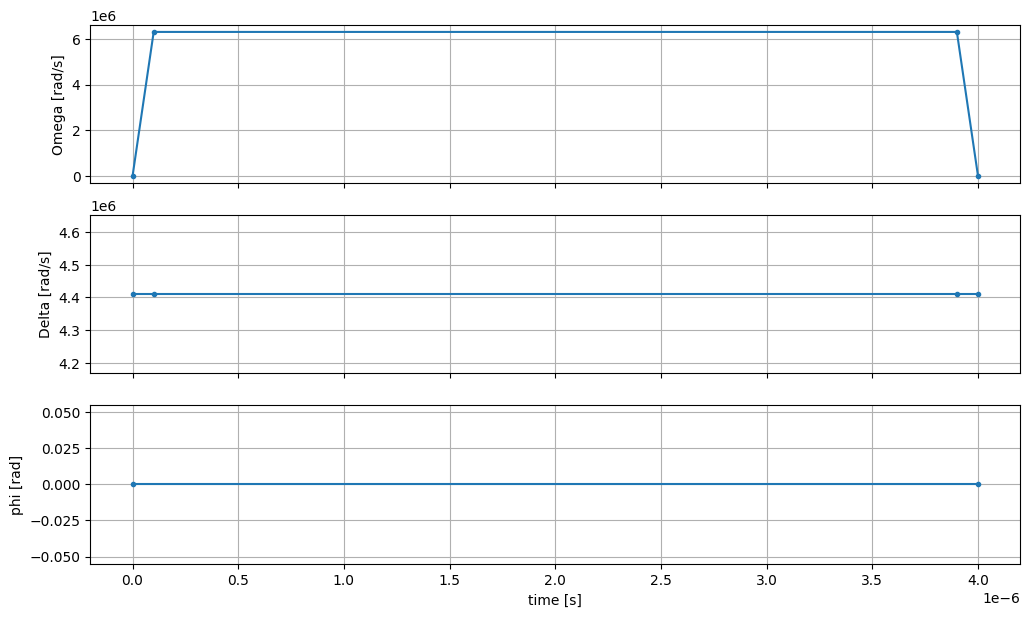

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
time_series = drive.amplitude.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Omega [rad/s]')

ax = axes[1]
time_series = drive.detuning.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Delta [rad/s]')

ax = axes[2]
time_series = drive.phase.time_series
# Note: time series of phase is understood as a piecewise constant function
ax.step(time_series.times(), time_series.values(), '.-', where='post');
ax.set_ylabel('phi [rad]')
ax.grid()
ax.set_xlabel('time [s]')

plt.show()  # this will show the plot below in an ipython or jupyter session


In [17]:

def run_simulation(device, register, drive, shots=1000):
    """Run the simulation on the given device and return the results.
    
    Args:
        device (Device): The device to run the simulation on
        register (AtomArrangement): The register to run the simulation on
        drive (DrivingField): The driving field to use in the simulation
        shots (int): The number of shots to run the simulation for
    
    Returns:
        Counter: The results of the simulation
    """
    ahs_program = AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=drive
    )
    result_simulator = device.run(ahs_program, shots=shots).result()
    return result_simulator

# ahs_program = AnalogHamiltonianSimulation(
#     register=register,
#     hamiltonian=drive
# )

def get_counts_summed_probabilities(result, shots, averaged_ndoes=None):
    """Aggregate probabilities of the summed states from AHS shot results
    
    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns:
        np.ndarray: probability of each summed state
    """
    state_counts = get_counts(result) # get state counts from simulator result
    n_prob = np.zeros(len(list(state_counts.keys())[0])) # initialize array of probabilities
    total_counts = {}
    for k, v in state_counts.items(): # sum counts of states with same number of spins up `1`
        new_k = k.count('1')
        total_counts[new_k] = total_counts.get(new_k, 0) + v
    for k, v in total_counts.items(): # convert counts to probabilities
        n_prob[k] = v / shots
    assert np.isclose(np.sum(n_prob), 1.0) # ensure probabilities sum to 1    
    if averaged_ndoes is not None:
        n_expectation = sum(n_prob * np.arange(len(n_prob)))
        return n_prob, n_expectation
    return n_prob

def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', '1', '0']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)

# counts_simulator = get_counts(result_simulator)  # takes about 5 seconds
# print(counts_simulator)

In [35]:
shots = 1_000_000
device = LocalSimulator("braket_ahs")
t_range = np.linspace(1e-7, 2.5*1e-6, 20)
my_nodesB = [2, 3]
n_prob_list = []
n_expectation_list = []

# run simulation for different drive durations
for t_max in t_range:
    drive = get_drive(t_max) # get drive with different duration
    result_simulator = run_simulation(device, register, drive, shots) # run simulation
    n_prob, n_expectation = get_counts_summed_probabilities(result_simulator, shots, my_nodesB) # get probabilities and expectation
    n_prob_list.append(n_prob)
    n_expectation_list.append(n_expectation)


# n_prob, counts_averaged = get_counts_summed_probabilities(simulator, shots, True)
# result_simulator = device.run(
#     ahs_program,
#     shots=shots
# ).result()  # takes about 5 seconds

Text(0, 0.5, '$\\langle n \\rangle$')

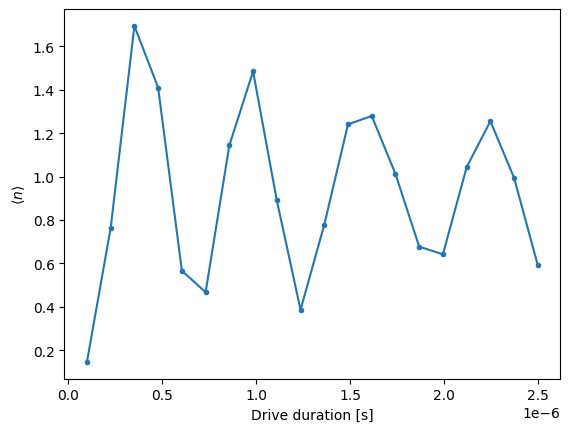

In [36]:
plt.plot(t_range, n_expectation_list, '.-')
plt.xlabel('Drive duration [s]')
# plt.ylabel(r'$\langle n \rangle$')
plt.ylabel(r'$\langle n \rangle$')

In [27]:
# n_prob, counts_averaged = get_counts_summed_probabilities(simulator, shots, True)
my_nodes = [0, 1]
np.arange(1, 9)[my_nodes]

array([1, 2])